<a href="https://colab.research.google.com/github/subhobrata/Natural-Language-Processing-From-Scratch/blob/master/Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import string
from collections import Counter
from pprint import pprint
import gzip
import matplotlib.pyplot as plt 
import numpy as np
from numpy.linalg import svd
from numpy import diag

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:

stopwords = set([word.lower().strip() for word in open("/content/gdrive/My Drive/data/nltk_stopwords.txt", "rt").readlines()])

In [0]:
def extract_words(text, stopwords):
    temp = text.split() # Split the text on whitespace
    text_words = []

    punctuation = set(string.punctuation)
    
    #Keep #tags and @mentions
    punctuation.remove("#")
    punctuation.remove("@")
    
    for word in temp:
        # Remove any punctuation characters present in the beginning of the word
        while len(word) > 0 and word[0] in punctuation:
            word = word[1:]

        # Remove any punctuation characters present in the end of the word
        while len(word) > 0 and word[-1] in punctuation:
            word = word[:-1]

        # Simple rule to eliminate (most) URLs
        if len(word) > 0 and "/" not in word:
            # If it's not a stopword
            if word.lower() not in stopwords:
                # Append this word into our list of words.
                text_words.append(word.lower())
        
    return text_words

In [0]:
tweets = []
line_count = 0

for line in open("/content/gdrive/My Drive/data/Apple-Twitter-Sentiment-DFE.csv", "rt"):
    fields = line.strip().split(',')
    
    line_count += 1
    
    # Skip the first line of the file which contains the header
    if line_count == 1:
        continue
    
    text = ",".join(fields[11:])
    
    if len(text) == 0:
        continue
    
    words = extract_words(text, stopwords)
    
    if len(words) > 0:
        tweets.append(words)
        
    if len(tweets) == 200:
        break

In [0]:
def inv_doc_freq(corpus_words):
    number_docs = len(corpus_words)
    
    document_count = {}

    for document in corpus_words:
        word_set = set(document)

        for word in word_set:
            document_count[word] = document_count.get(word, 0) + 1
    
    IDF = {}
    
    for word in document_count:
        IDF[word] = np.log(number_docs/document_count[word])
        
    
    return IDF

def tf_idf(corpus_words):
    IDF = inv_doc_freq(corpus_words)
    
    TFIDF = []
    
    for document in corpus_words:
        TFIDF.append(Counter(document))
    
    for document in TFIDF:
        for word in document:
            document[word] = document[word]*IDF[word]
            
    return TFIDF

In [0]:
TFIDF = tf_idf(tweets)

In [0]:
def build_vocabulary(TFIDF):
    words = set()
    
    for document in TFIDF:
        words |= document.keys()
    
    word_list = list(words)
    word_dict = dict(zip(word_list, range(len(word_list))))
    
    return word_dict, word_list

In [0]:
word_dict, word_list = build_vocabulary(TFIDF)

In [11]:

vocabulary_size = len(word_dict)
print("We have", vocabulary_size, "words in our vocabulary")

We have 927 words in our vocabulary


In [0]:
def term_document_matrix(TFIDF, word_list, word_dict):
    vocabulary_size = len(word_dict)
    number_documents = len(TFIDF)
    
    TDM = np.zeros((vocabulary_size, number_documents))
    
    for doc in range(number_documents):
        document = TFIDF[doc]
        
        for word in document.keys():
            pos = word_dict[word]
            
            TDM[pos, doc] = document[word]
            
    return TDM

In [13]:
TDM = term_document_matrix(TFIDF, word_list, word_dict)
print("Our dataset has:\n%u unique words\n%u documents"%(TDM.shape))

Our dataset has:
927 unique words
200 documents


In [0]:
new_tweet = ['macbook', 'mini', 'rocket']

In [0]:
def find_related_docs(tweet, TDM):
    new_vector = np.zeros(TDM.shape[1])
    
    for word in tweet:
        pos = word_dict[word]
        new_vector += TDM[pos, :]
        
    # Now the entries of new_vector tell us which documents are activated by this one.
    # Let's extract the list of documents sorted by activation
    doc_list = sorted(zip(range(TDM.shape[1]), new_vector), key=lambda x:x[1], reverse=True)
    
    return doc_list

In [0]:
related = find_related_docs(new_tweet, TDM)

In [17]:

for tweet, score in related[:5]:
    print(tweet, " ".join(tweets[tweet]))

17 jh hines staff newly issued @apple #connected macbook ipad mini #txed
34 rt @tra_hall jh hines staff newly issued @apple #connected macbook ipad mini #txed #txed
2 #aapl:5 rocket stocks buy december gains apple
166 ipad mini unboxing via @youtube @apple #ipadmini #ipad #macbook #macbookpro #startup #hipster #unboxing
167 ipad mini first time startup via @youtube @apple #ipadmini #ipad #macbook #macbookpro #startup #hipster #unbox


In [0]:

def similarity(vec1, vec2):
    sim = np.dot(vec1, vec2)
    norm1 = np.sqrt(np.dot(vec1, vec1))
    norm2 = np.sqrt(np.dot(vec2, vec2))
    
    return sim/(norm1*norm2)

In [0]:
def find_similar_words(tweet, TDM):
    new_vector = np.zeros(TDM.shape[1])
    
    for word in tweet:
        pos = word_dict[word]
        new_vector += TDM[pos, :]
    
    sim = [similarity(new_vector, TDM[i, :]) for i in range(TDM.shape[0])]
    
    sim_words = sorted(zip(range(TDM.shape[0]), sim), key=lambda x:x[1], reverse=True)
    
    return sim_words

In [0]:
similar = find_similar_words(new_tweet, TDM)

In [21]:
for word, score in similar[:5]:
    print(word_list[word], score)

macbook 0.7640071602554539
mini 0.7398422630773179
ipad 0.6849608378181927
#macbook 0.66219576837537
#startup 0.6273056189756162


In [0]:

u, sigma, vt = svd(TDM)

In [23]:
m, n = TDM.shape
print(u.shape, sigma.shape, vt.shape)

(927, 927) (200,) (200, 200)


In [0]:
k = 10

# Convert the vector of singular values into a diagonal matrix
sigma_k = sigma[:k]
Sk = diag(sigma_k)

# Drop the extraneous dimensions in the other two matrices.
uk = u[:,:k]
vtk = vt[:k, :]

In [25]:
print(uk.shape, Sk.shape, vtk.shape)

(927, 10) (10, 10) (10, 200)


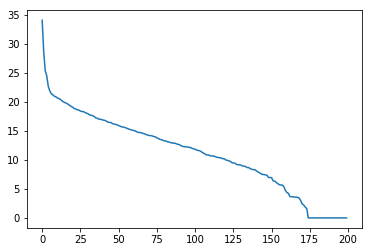

In [26]:

plt.plot(sigma)

In [0]:
# Sort the list of words by the weight they have in a specific topic
def top_words(vector, word_list):
    doc_list = sorted(zip(word_list, vector), key=lambda x:x[1], reverse=True)
    
    return doc_list

In [28]:

topic_words = top_words(uk[:,3], word_list)
for word, weight in topic_words[:10]:
    print(word, weight)

#4 0.16912068258106042
sold 0.16912068258106036
#nasdaq100 0.16912068258106028
10.49 0.16912068258106025
#exit 0.16912068258106025
#forex 0.16912068258106025
#gain 0.16912068258106025
#recent 0.16912068258106025
20 0.16912068258106025
#market 0.16842637000189195


In [0]:
document = ['ipad', 'mini', 'price']

doc_vector = np.zeros(vocabulary_size)
for word in document:
    doc_vector[word_dict[word]] += 1

In [30]:
doc_singular = 1/sigma_k*np.dot(uk.T, doc_vector)
pprint(doc_singular)

array([ 1.62243400e-04, -1.44900491e-02,  1.09973213e-03, -4.30257980e-05,
       -9.69106965e-04,  4.54646796e-03, -7.58613138e-04,  2.40772326e-03,
       -3.82599561e-03,  1.95924079e-03])


In [31]:
topic = np.argmax(doc_singular)

topic_words = top_words(uk[:,topic], word_list)
for word, weight in topic_words[:10]:
    print(word, weight)

stock 0.2452591443094601
thanks 0.21154642574531066
today 0.16895384229736377
#aapl 0.1659547611444024
trading 0.1400459620968507
apple's 0.12260529463519178
behind 0.118667013894756
lot 0.11665431614358651
one 0.11230851763068464
best 0.11228276075549404


In [0]:
def NMF(V, k):
    n, m = V.shape

    W = np.random.rand(n, k)
    H = np.random.rand(k, m)

    error = 1
    err = 1

    while err > 1e-4:
        old_error = error

        hn = np.dot(W.T, V)
        hd = np.dot(W.T, np.dot(W, H))

        H = H*hn/hd

        wn = np.dot(V, H.T)
        wd = np.dot(W, np.dot(H, H.T))

        W = W*wn/wd

        error = np.sum(np.power(V-np.dot(W, H), 2.0))
        err = np.abs(old_error-error)

    return W, H, error

In [33]:
error = []

for comps in range(2, 35+1):
    W, H, err = NMF(TDM, comps)
    print(comps, err)
    error.append(err)

2 32018.59999809094
3 31374.12632215434
4 30779.3905189132
5 30297.040148221713
6 29796.433113717656
7 29343.352676474162
8 28965.301384630962
9 28484.795155413813
10 28069.534636533146
11 27614.945611471994
12 27180.346864563136


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


13 nan
14 26422.674240560806
15 26003.417219489464
16 25653.315625328054
17 25245.278821195905
18 24902.995512766003
19 24591.205696342615
20 24211.021907875063
21 23796.422487521562
22 23523.832511413246
23 23068.61353346526
24 nan
25 22387.065369792905
26 22069.108930678864
27 21752.872953549064
28 21426.87844110954
29 21183.148918806015
30 20736.460965193863
31 20557.405581304
32 20180.560616473525
33 nan
34 19489.25983167769
35 19274.463975845574


Text(0.5, 1.0, 'Non-Negative Matrix Factorization')

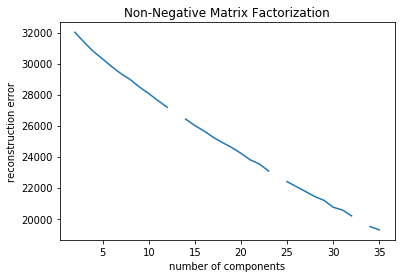

In [34]:
plt.plot(range(2, 35+1), error)
plt.xlabel('number of components')
plt.ylabel('reconstruction error')
plt.title('Non-Negative Matrix Factorization')

In [0]:
W, H, err = NMF(TDM, 30)

In [36]:
topic_words = top_words(W[:,0], word_list)
for word, weight in topic_words[:10]:
    print(word, weight)

events 24.12343364162138
outlook 24.12343364162138
#tsla 24.12343364162138
amid 24.12343364162138
heavy 24.12343364162138
economic 24.12343364162138
options 24.12343364162138
#markets 24.12343364162138
#premarket 24.12343364162138
week 24.12343364162138


In [37]:
topic_words = top_words(W[:,10], word_list)
for word, weight in topic_words[:10]:
    print(word, weight)

#startup 33.31874689860513
#hipster 33.31874689860513
@youtube 33.31874689860513
#macbook 32.70139061113297
#macbookpro 32.53721503675662
via 30.89866059285561
#ipadmini 21.543578004430053
startup 21.121325552423386
first 20.254212284842524
#ipad 19.766118479459212
